# Gold Recovery from Ore

Prepare a prototype of a machine learning model for "Cifra". The company develops solutions for efficient operation of industrial enterprises.

The model should predict the gold recovery coefficient from gold-bearing ore using mining and purification parameters.

The model will help optimize production to prevent the operation of a facility with unprofitable characteristics.

## Data Preprocessing 

In [1]:
# libraries import
import numpy as np 
import pandas as pd
import seaborn as sns

from sklearn import tree
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

Open three datasets and save them in deparate pandas dataframes

In [2]:
full = pd.read_csv('gold_recovery_full_new.csv') 
test = pd.read_csv('gold_recovery_test_new.csv')
train = pd.read_csv('gold_recovery_train_new.csv')

Let's verify that the enrichment efficiency is calculated correctly using `effectiveness` function:

In [3]:
def effectiveness(data): 
    C = data['rougher.output.concentrate_au']
    F=data['rougher.input.feed_au']
    T=data['rougher.output.tail_au']
    try:
        recovery = (C*(F-T))/(F*(C-T))*100
        return recovery
    except:
        return np.nan

In [4]:
train_clean = train.dropna()
effectiveness(train_clean).describe() 

count    11017.000000
mean        82.741888
std         13.590523
min         -0.000000
25%         79.997468
50%         84.847754
75%         89.635149
max        100.000000
dtype: float64

And now we can look at the given values:

In [5]:
train_clean['rougher.output.recovery'].describe()

count    11017.000000
mean        82.741888
std         13.590523
min          0.000000
25%         79.997468
50%         84.847754
75%         89.635149
max        100.000000
Name: rougher.output.recovery, dtype: float64

Let's calculate the deviation of the mean absolute error between the calculated and existing values of the enrichment efficiency:

In [6]:
print('MAE =', mean_absolute_error(effectiveness(train_clean), train_clean['rougher.output.recovery']))


MAE = 9.82970122149377e-15


The parameter "recovery" in the training set has been calculated correctly, and the error deviation is minimal.

Let's analyze the features that are not available in the test dataset.

In [7]:
set(train.columns)-set(test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

The list is quite long, so let's refer to the technical specification and examine the variables. In the test dataset, only the parameters defined at the start, before the start of the technological process, are included. Therefore, the identified features above are characteristic of the subsequent stages of ore processing.

Let's fill in the missing values in the three datasets and proceed with the data analysis. We will use the KNNImputer method and borrow values from neighboring instances for the missing values.

In [8]:
imputer = KNNImputer() 
full.loc[:, full.columns != 'date'] = imputer.fit_transform(full.loc[:, full.columns != 'date'])
train.loc[:, train.columns != 'date'] = imputer.fit_transform(train.loc[:, train.columns != 'date'])
test.loc[:, test.columns != 'date'] = imputer.fit_transform(test.loc[:, test.columns != 'date'])


## Data analysis

### Let's observe how the concentration of metals (Au, Ag, Pb) changes at different stages of purification.

We will visualize the data using box plots.

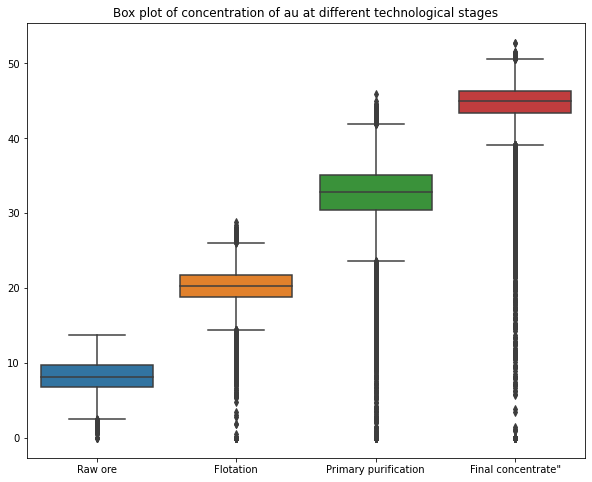

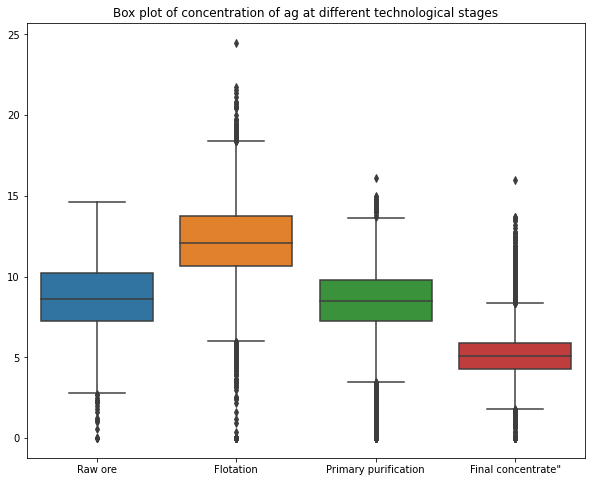

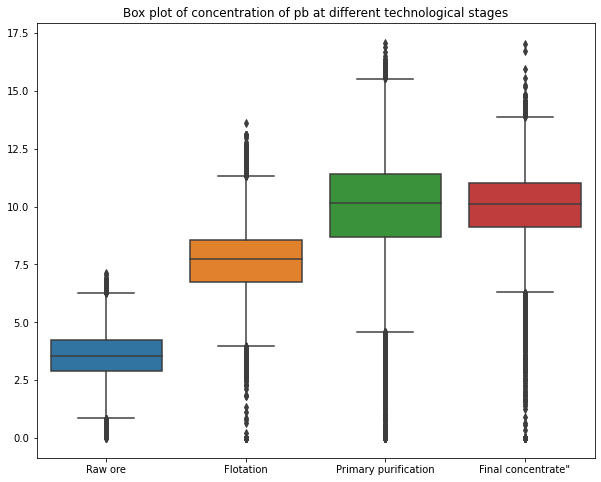

In [9]:
elements = {'abu': 'au', 
          'ag': 'ag',
           'pb': 'pb'}
# generate box plots for the concentration of metals at different stages
for key in elements.keys(): 
    plt.figure(figsize=(10,8))
    plt.title('Box plot of concentration of {} at different technological stages'.format(elements[key]))
    sns.boxplot(data=full[['rougher.input.feed_' + elements[key],
                           'rougher.output.concentrate_' + elements[key], 
                           'primary_cleaner.output.concentrate_'+ elements[key], 
                           'final.output.concentrate_' + elements[key],]])
    plt.xticks([0,1,2,3], ['Raw ore', 'Flotation', 'Primary purification', 'Final concentrate"'])
plt.show()

Clearly, the gold concentration is increasing, which is a positive sign. The concentrations of lead and silver show a slight increase after flotation, followed by a decrease.

Let's compare the distributions of raw ore grain sizes in the training and test datasets.

We will visualize the data using distplot:

/Users/ivanshurgalin/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


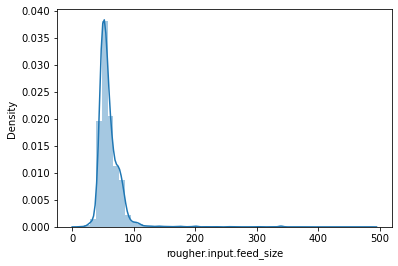

In [10]:
# train set
sns.distplot(train['rougher.input.feed_size']);  
 

/Users/ivanshurgalin/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


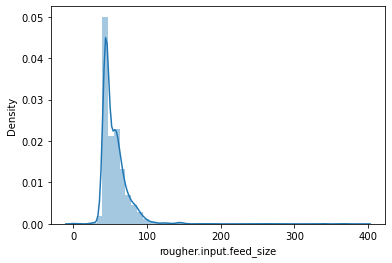

In [11]:
# test set
sns.distplot(test['rougher.input.feed_size']);

/Users/ivanshurgalin/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/ivanshurgalin/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


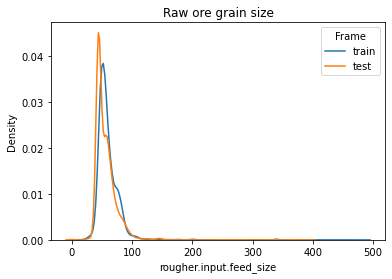

In [12]:
for frame,name in zip([train,test],
                       ["train","test"]):
    subset = frame["rougher.input.feed_size"]

    sns.distplot(subset, hist = False, kde = True,
                 label = name)
plt.legend(prop={'size': 10}, title = 'Frame')
plt.title('Raw ore grain size');

The distributions are almost identical, but in the training dataset, there is a predominance of values around 50 and above, while in the test dataset, a significant number of objects are concentrated near the threshold of 50. From this, we can conclude that during the technological process, there is a tendency for the grain sizes to decrease.

## Let's investigate the total concentration of all substances at different stages: in the raw ore, in the rough and final concentrates, for anomalies in the dataset

In [13]:
#Let's declare a function for anomaly filtering:
def filter_outliers(df, column_name, remove_outliers=False):
    df_column = df[column_name]
    quartile_1 = df_column.describe()['25%']
    quartile_3 = df_column.describe()['75%']
    interquartile_range = quartile_3 - quartile_1
    upper_whisker = quartile_1 + 1.5 * interquartile_range
    lower_whisker = max(quartile_1 - 1.5 * interquartile_range, df_column.min())
    outliers = df[(df_column < lower_whisker) | (df_column > upper_whisker) |
                 (df_column.isnull())]
    if remove_outliers:
        df.drop(outliers.index, inplace=True)


Let's take a look at the train dataset

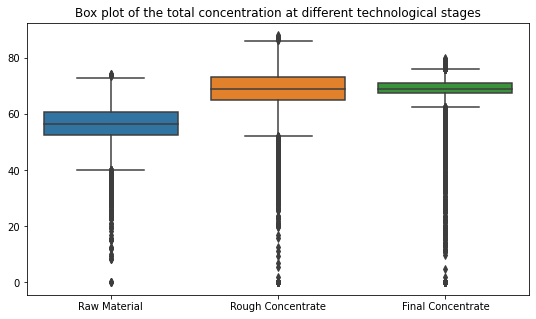

In [14]:
# sum up the incoming raw material
train['rougher.input.feed_sum'] = train['rougher.input.feed_ag'] + train['rougher.input.feed_pb'] + train['rougher.input.feed_sol'] + train['rougher.input.feed_au']
train['final.output.concentrate_sum'] = train['final.output.concentrate_ag'] + train['final.output.concentrate_pb'] + train['final.output.concentrate_sol'] + train['final.output.concentrate_au']
# now after flotation
train['rougher.output.concentrate_sum'] = train['rougher.output.concentrate_ag'] + train['rougher.output.concentrate_pb'] + train['rougher.output.concentrate_sol'] + train['rougher.output.concentrate_au']
# visualize the results
plt.figure(figsize=(9,5)) 
plt.title('Box plot of the total concentration at different technological stages')
sns.boxplot(data=train[['rougher.input.feed_sum','rougher.output.concentrate_sum', 'final.output.concentrate_sum']])
plt.xticks([0,1,2], ['Raw Material','Rough Concentrate','Final Concentrate'])
plt.show()

In [15]:
# outlier filtering
columns = ['rougher.input.feed_sum','rougher.output.concentrate_sum','final.output.concentrate_sum']
for column_name in columns:
    filter_outliers(train, column_name, remove_outliers=True)
num_rows_before = train.shape[0]

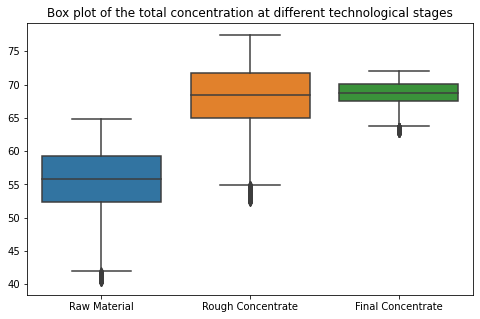

In [16]:
# visualize the data
plt.figure(figsize=(8,5))
plt.title('Box plot of the total concentration at different technological stages')
sns.boxplot(data=train[['rougher.input.feed_sum','rougher.output.concentrate_sum', 'final.output.concentrate_sum']])
plt.xticks([0,1,2], ['Raw Material','Rough Concentrate','Final Concentrate'])
plt.show()

The number of outliers has significantly reduced. We can assume that there might be some inherent error or scanning issues during the processing of the raw material.

To maintain the integrity of the training dataset, let's reset the values:

In [17]:
train = train.drop(['rougher.input.feed_sum','final.output.concentrate_sum','rougher.output.concentrate_sum'], axis=1)


## Model

### Declare a function for sMAPE calculation

In [18]:
def smape_end(target_rougher, predict_rougher, target_final, predict_final):
    smape_rougher = 100/len(target_rougher) * np.sum(2 * np.abs(predict_rougher - target_rougher) / 
                                                     (np.abs(target_rougher) + np.abs(predict_rougher)))
    smape_final = 100/len(target_final) * np.sum(2 * np.abs(predict_final - target_final) / 
                                                 (np.abs(target_final) + np.abs(predict_final)))
    return 0.25*(smape_rougher) + 0.75*(smape_final)

Let's standardize the indexing and prepare the data for model training and calculating sMAPE

In [19]:
train.set_index('date', inplace=True)
full.set_index('date', inplace=True)
test.set_index('date', inplace=True)

In [20]:
test['rougher.output.recovery'] = full['rougher.output.recovery']
test['final.output.recovery'] = full['final.output.recovery']
features_train_1 = train.drop(set(train.columns)-set(test.columns), axis=1).filter(regex='^rougher',axis=1)
features_train_1 = features_train_1.drop(['rougher.output.recovery'], axis=1)
target_train_1 = train['rougher.output.recovery']
features_train_2 = train.drop(set(train.columns)-set(test.columns), axis=1)
features_train_2 = features_train_2.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_2 = train['final.output.recovery']
features_test_1 = test.filter(regex='^rougher',axis=1).drop(['rougher.output.recovery'], axis=1)
target_test_1 = test['rougher.output.recovery']
features_test_2 = test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_2 = test['final.output.recovery']

### Decision tree model

In [21]:
for depth in range(1, 7):
    model = tree.DecisionTreeRegressor(random_state=12345, max_depth = depth)
    y_pred_1 = cross_val_predict(model, features_train_1, target_train_1, cv=5)
    y_pred_2 = cross_val_predict(model, features_train_2, target_train_2, cv=5)
    print('depth',depth)
    print('Final sMAPE:',smape_end(target_train_1, y_pred_1, target_train_2, y_pred_2))
print()

depth 1
Final sMAPE: 8.948105071208882
depth 2
Final sMAPE: 8.498908484606972
depth 3
Final sMAPE: 8.411054739646124
depth 4
Final sMAPE: 9.082581891994282
depth 5
Final sMAPE: 9.227978447323647
depth 6
Final sMAPE: 9.80118470489381



### Random forest model:

In [22]:
for depth in range(5, 8):
    print('depth',depth)
    for num in range(27, 40, 3):
        model_1 = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators = num)
        y_pred_1 = cross_val_predict(model_1, features_train_1, target_train_1, cv=5)
        y_pred_2 = cross_val_predict(model_1, features_train_2, target_train_2, cv=5)
        print('num',num)
        print('Final sMAPE:',smape_end(target_train_1, y_pred_1, target_train_2, y_pred_2))
    print()
    
print()

depth 5
num 27
Final sMAPE: 8.325558825944468
num 30
Final sMAPE: 8.301723773046247
num 33
Final sMAPE: 8.274113090306493
num 36
Final sMAPE: 8.287779544996331
num 39
Final sMAPE: 8.275972778738057

depth 6
num 27
Final sMAPE: 8.52251866037476
num 30
Final sMAPE: 8.484758090417941
num 33
Final sMAPE: 8.457180616147276
num 36
Final sMAPE: 8.464809771680864
num 39
Final sMAPE: 8.465094808830443

depth 7
num 27
Final sMAPE: 8.695009989503683
num 30
Final sMAPE: 8.623424727218968
num 33
Final sMAPE: 8.60651931775736
num 36
Final sMAPE: 8.599670907388823
num 39
Final sMAPE: 8.595618063661595




### Linear regression

In [23]:
model_2 = LinearRegression()
y_pred_1 = cross_val_predict(model_2, features_train_1, target_train_1, cv=5)
y_pred_2 = cross_val_predict(model_2, features_train_2, target_train_2, cv=5)
print('Итоговое sMAPE:',smape_end(target_train_1, y_pred_1, target_train_2, y_pred_2))

Итоговое sMAPE: 10.035071820618766


Let's evaluate the performance of the random forest model with the optimized hyperparameters (max_depth = 5 and n_estimators = 39) on the test datase

In [24]:
model_test_1 = RandomForestRegressor(random_state=12345, max_depth=5, n_estimators = 39)
model_test_2 = RandomForestRegressor(random_state=12345, max_depth=5, n_estimators = 39)
model_test_1.fit(features_train_1, target_train_1)
model_test_2.fit(features_train_2, target_train_2)
y_pred_1 = pd.Series(model_test_1.predict(features_test_1))
y_pred_2 = pd.Series(model_test_2.predict(features_test_2))
target_test_1 = target_test_1.reset_index(drop=True)
target_test_2 = target_test_2.reset_index(drop=True)
smape_end(target_test_1, y_pred_1, target_test_2, y_pred_2)

9.175781422581979

To assess the adequacy of the model, let's train a constant model and calculate the sMAPE:

In [25]:
dummy_regr_1 = DummyRegressor(strategy="mean")
dummy_regr_2 = DummyRegressor(strategy="mean")
dummy_regr_1.fit(features_train_1, target_train_1)
dummy_regr_2.fit(features_train_2, target_train_2)
y_pred_1 = dummy_regr_1.predict(features_test_1)
y_pred_2 = dummy_regr_2.predict(features_test_2)
smape_end(target_test_1, y_pred_1, target_test_2, y_pred_2)

9.99514969948807

So, the error of the selected model is lower than that of the constant model.

## Summary:
The data has been extracted and preprocessed, and the features that were not available in the test dataset have been analyzed. Changes in the concentration of metals and the sizes of granules at different stages of ore processing have been examined. 

- The formula for enrichment efficiency has been verified.
- The final prediction model has been built using the RandomForest algorithm.
- The error on the test dataset is 9.03.
- The hyperparameters of the algorithm are: max_depth = 5 and n_estimators = 39.